# 4. Treinamento do Modelo:

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [87]:
df = pd.read_parquet('data/vendas.parquet')

In [88]:
df = df[df['year'] > 2021]

In [89]:
##dias de venda
len(df['dtvenda'].unique())

699

In [90]:
df['vlvendido'] = df['qtd']* df['vlunitario']

In [91]:
df = df.sort_values(by='dtvenda').reset_index()

In [92]:
df = df.groupby(['day_of_week', 'month', 'day_of_year', 'year'])\
            [['qtd', 'vlvendido']].sum().reset_index()

In [93]:
df.shape

(699, 6)

## 4.1 - Método de Treinamento: Divisão Treino/Teste ou Validação Cruzada

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [95]:
windows_size = 30 # ref. day  -- 30/60
train_size = None # ref. day
val_size = 0 # ref. day
test_size = 156 # ref. day

flag_stationary = False

features = ['day_of_week', 'month', 'day_of_year', 'year', 'qtd', 'vlvendido']

if train_size is None:
    train_size = len(df) - val_size - test_size

print(f'windows_size = {windows_size}')
print(f'train_size = {train_size}')
print(f'val_size = {val_size}')
print(f'test_size = {test_size}')
print(f'features = {features}')


windows_size = 30
train_size = 543
val_size = 0
test_size = 156
features = ['day_of_week', 'month', 'day_of_year', 'year', 'qtd', 'vlvendido']


In [96]:
def create_dataset(df, windows_size):
    
    X = []
    y = []
    
    for i in range(len(df) - windows_size):
        
        pos_target = i + windows_size
        target = df.iloc[pos_target]['qtd']
        
        sample = []
        for f in features:
            if f == 'qtd':
                sample += list(df.iloc[i:pos_target][f].values)
            else:
                sample += [df.iloc[pos_target][f]]
        
        X.append(sample)
        y.append(target)
    
    return np.array(X), np.array(y)

In [97]:
X, y = create_dataset(df, windows_size=windows_size)

X.shape, y.shape

((669, 35), (669,))

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [99]:
X_scaled

array([[-1.58517062, -0.92950515, -0.8847914 , ..., -0.29554973,
        -0.67353821, -0.56404412],
       [-1.58517062, -0.92950515, -0.81663424, ..., -0.67394926,
        -0.52940481, -0.41365988],
       [-1.58517062, -0.63240102, -0.76795055, ..., -0.52979706,
        -0.36725472,  0.67830331],
       ...,
       [ 1.45345157,  1.74443203,  1.81228471, ..., -0.40366388,
        -0.42130475, -0.02312244],
       [ 1.45345157,  1.74443203,  1.82202145, ..., -0.4216829 ,
        -0.02493788, -0.54713168],
       [ 1.45345157,  1.74443203,  1.88044187, ..., -0.02526434,
        -0.51138813,  0.02436714]])

In [100]:
X_test, y_test = X_scaled[-test_size:, :], y[-test_size:]
X_train, y_train = X_scaled[-test_size-val_size-train_size:-test_size-val_size, :], y[-test_size-val_size-train_size:-test_size-val_size]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((513, 35), (513,), (156, 35), (156,))

In [101]:
y

array([ 11.,  20.,  86.,  22.,   1.,  33.,  17.,  20.,  39.,  29.,   7.,
        18.,  13.,  10., 154.,  20.,  14.,  32.,  16.,  20.,  15.,  10.,
         7.,  10.,  31.,  15.,  58.,  58.,  67.,  22.,  28.,  26.,   9.,
        21.,  10.,  12.,  27.,  10.,  13.,  40.,  21.,  16.,  28.,  17.,
        30.,   8., 232.,  83.,  15.,  22.,  14.,  18.,  21.,  39., 102.,
         9.,  17.,  25.,  11.,   6.,  20.,  57.,  32.,   7.,  13.,  31.,
        47.,  12.,  28.,  82., 333.,  13.,  42.,  14.,  61.,  34.,  27.,
         9.,  10.,  29.,  19.,  45.,  19.,  40.,  82.,  25.,  24.,  11.,
        16.,  18.,  24.,  18.,   6.,  20.,   3., 198., 299.,   1.,  41.,
        13.,   6., 152.,   5.,  20.,  25.,  34., 252.,  11.,  55.,   8.,
        28.,   6.,  23.,  14.,   8.,  12.,  82.,   6.,  19.,  18.,   2.,
        25.,   3.,  19.,  24.,  26.,   7.,  22.,  72.,  35., 346.,  42.,
        37.,  90.,   4.,  13.,  26.,   7.,  55.,  15.,  13.,  37.,  49.,
        99.,  26.,  58.,  61.,  23.,  29.,  10.,  4

## 4.2 - Pelo menos dois Modelos: Linear, Árvore, Ensemble, KNN, etc.

Os modelos utilizados serão:
- LinearRegression
- DecisionTreeRegressor
- AdaBoostRegressor
- RandomForestRegressor

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

In [103]:
def get_model_linear_regression():
    return LinearRegression()

def get_model_decision_tree(max_depth=5, max_leaf_nodes=5):
    return DecisionTreeRegressor(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=42)

def get_model_adaboost(n_estimators=50, learning_rate=0.5, loss='linear'):
    return AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, loss=loss, random_state=42)

def get_model_random_forest(n_estimators=50,max_depth=5):
    return RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

In [104]:
def predict(sample, model):
    
    predictions = []
    
    test_info = X_test[:, windows_size:]
    
    sample_to_predict = [sample.copy()]

    for i in range(test_size):

        sample_to_predict = sample_to_predict[0]

        if i > 0:
            sales = list(sample_to_predict[1:windows_size]) + [y]
            others = list(test_info[i])
            
            sample_to_predict = sales + others

        sample_to_predict = np.array([sample_to_predict])
        y = model.predict(sample_to_predict)[0]
        
        predictions.append(y)
    
    return predictions

In [105]:
def result_summary(model_name, hp, y_pred, y_test):
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = root_mean_squared_error(y_pred, y_test)
    return {"model_name": model_name, "hyper_parameters": hp,
            "mae": mae, "mse": mse, "rmse": rmse}


In [106]:
model = get_model_linear_regression()
model.fit(X_train, y_train)

y_pred = predict(X_test[0,:], model)

In [107]:
lr_result = result_summary("linear_regression", {}, y_pred, y_test)

In [108]:
lr_result

{'model_name': 'linear_regression',
 'hyper_parameters': {},
 'mae': np.float64(1046869.9877903217),
 'mse': np.float64(9591037895844.543),
 'rmse': np.float64(3096940.085930715)}

## 4.3 - Hiperparâmetros

In [109]:
decision_tree_params = [
    {"max_depth": 5, "max_leaf_nodes": 5},
    {"max_depth": 3, "max_leaf_nodes": 10},
    {"max_depth": 10, "max_leaf_nodes": 5},
    {"max_depth": 10, "max_leaf_nodes": 10},
    {"max_depth": 10, "max_leaf_nodes": 3}
]

adaboost_params = [
    {"n_estimators": 50, "learning_rate": 0.5, "loss": "linear"},
    {"n_estimators": 100, "learning_rate": 0.5, "loss": "linear"},
    {"n_estimators": 50, "learning_rate": 0.1, "loss": "linear"},
    {"n_estimators": 100, "learning_rate": 0.1, "loss": "linear"}
]

random_forest_params = [
    {"n_estimators": 50, "max_depth": 5},
    {"n_estimators": 100, "max_depth": 5},
    {"n_estimators": 50, "max_depth": 10},
    {"n_estimators": 100, "max_depth": 10}
]

## 4.4 - Treinamentos

In [110]:
resultados = [lr_result]


### 4.4.1 - Arvore de Decisão

In [111]:
for param in decision_tree_params:
    model = get_model_decision_tree(**param)
    model.fit(X_train, y_train)

    y_pred = predict(X_test[0,:], model)
    rs = result_summary("decision_tree", param, y_pred, y_test)
    resultados.append(rs)

### 4.4.2 - Adaboost

In [112]:
for param in adaboost_params:
    model = get_model_adaboost(**param)
    model.fit(X_train, y_train)

    y_pred = predict(X_test[0,:], model)
    rs = result_summary("adaboost", param, y_pred, y_test)
    resultados.append(rs)

### 4.4.3 - Random Forest

In [113]:
for param in random_forest_params:
    model = get_model_random_forest(**param)
    model.fit(X_train, y_train)

    y_pred = predict(X_test[0,:], model)
    rs = result_summary("random_forest", param, y_pred, y_test)
    resultados.append(rs)

# 5 - Avaliação

## 5.1 - Métricas

Por se tratar de um problema de regressão, iremos utilizar as métricas:

- **MAE** (Mean Absoluto Error): Erro Médio Absoluto
- **MSE** (Mean Squared Error): Erro Quadrático Médio
- **RMSE** (Root Mean Squared Error): Raiz do Erro Quadrático Médio

In [114]:
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='rmse', ascending=True)

,model_name,hyper_parameters,mae,mse,rmse
13,random_forest,"{'n_estimators': 100, 'max_depth': 10}",2.937964e+00,2.318022e+01,4.814584e+00
11,random_forest,"{'n_estimators': 100, 'max_depth': 5}",3.186662e+00,2.398486e+01,4.897434e+00
12,random_forest,"{'n_estimators': 50, 'max_depth': 10}",3.036820e+00,2.464980e+01,4.964857e+00
10,random_forest,"{'n_estimators': 50, 'max_depth': 5}",3.306393e+00,2.626150e+01,5.124597e+00
4,decision_tree,"{'max_depth': 10, 'max_leaf_nodes': 10}",5.544658e+00,5.501560e+01,7.417250e+00
8,adaboost,"{'n_estimators': 50, 'learning_rate': 0.1, 'lo...",7.455403e+00,8.141340e+01,9.022937e+00
9,adaboost,"{'n_estimators': 100, 'learning_rate': 0.1, 'l...",8.018569e+00,8.923768e+01,9.446570e+00
2,decision_tree,"{'max_depth': 3, 'max_leaf_nodes': 10}",7.770058e+00,8.965933e+01,9.468861e+00
7,adaboost,"{'n_estimators': 100, 'learning_rate': 0.5, 'l...",8.305503e+00,9.527599e+01,9.760942e+00
6,adaboost,"{'n_estimators': 50, 'learning_rate': 0.5, 'lo...",8.305503e+00,9.527599e+01,9.760942e+00


In [115]:
df_resultados.to_csv('data/resultados.csv')

## 5.2 - Comparação dos Modelos

### 5.2.1 - Random Forest

**Melhor resultado**

Analisando os hiperparametros, aumentando a profundidade maxima e o numero de estimadores, houve uma melhora no resultado


In [116]:
df_resultados[df_resultados['model_name']== 'random_forest']\
        .sort_values(by='rmse', ascending=True).head(2)

,model_name,hyper_parameters,mae,mse,rmse
13,random_forest,"{'n_estimators': 100, 'max_depth': 10}",2.937964,23.180224,4.814584
11,random_forest,"{'n_estimators': 100, 'max_depth': 5}",3.186662,23.984857,4.897434


### 5.2.2 - Decision Tree

**Segundo Melhor resultado**

Analisando os hiperparametros, da mesma forma que o Random Forest, houve melhora com o aumento da profundidade. O numero de folhas também altera o resultado.

In [122]:
df_resultados[df_resultados['model_name']== 'decision_tree']\
        .sort_values(by='rmse', ascending=True).head(2)

,model_name,hyper_parameters,mae,mse,rmse
4,decision_tree,"{'max_depth': 10, 'max_leaf_nodes': 10}",5.544658,55.015598,7.417250
2,decision_tree,"{'max_depth': 3, 'max_leaf_nodes': 10}",7.770058,89.659334,9.468861


### 5.2.3 - Adaboost

**Terceiro melhor resultado**

Diferente do Random Forest, a redução do numero de estimadores melhorou o resultado do treino.

In [118]:
df_resultados[df_resultados['model_name']== 'adaboost']\
        .sort_values(by='rmse', ascending=True).head(2)

,model_name,hyper_parameters,mae,mse,rmse
8,adaboost,"{'n_estimators': 50, 'learning_rate': 0.1, 'lo...",7.455403,81.413398,9.022937
9,adaboost,"{'n_estimators': 100, 'learning_rate': 0.1, 'l...",8.018569,89.237678,9.446570


### 5.2.4 - Linear Regression

**Modelo apenas para referência**

Resultado serve como referencia para comparar com os demais modelos.

In [119]:
df_resultados[df_resultados['model_name']== 'linear_regression']\
        .sort_values(by='rmse', ascending=True).head(2)

,model_name,hyper_parameters,mae,mse,rmse
0,linear_regression,{},1.046870e+06,9.591038e+12,3.096940e+06


## 5.3 - Apresentação do Melhor resultado

In [123]:
model = get_model_random_forest(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred = predict(X_test[0,:], model)

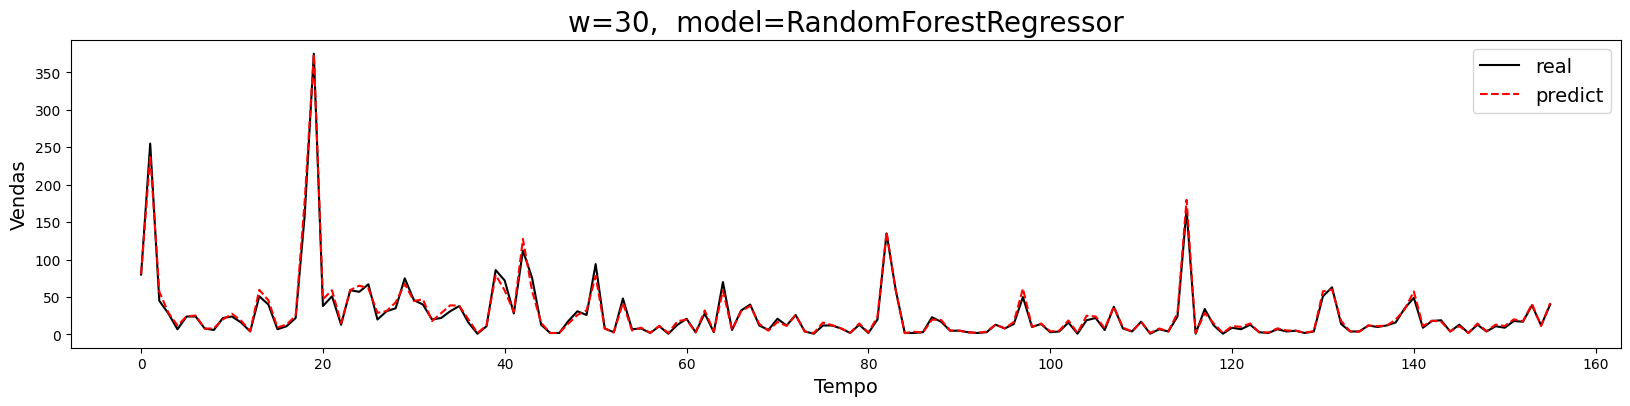

In [124]:
plt.figure(figsize=(20,4))
plt.title(f'w={windows_size},  model={model.__class__.__name__}', fontsize=20)
plt.plot(y_test, 'k', label='real')
plt.plot(y_pred, 'r--', label='predict')
plt.ylabel('Vendas', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.legend(fontsize=14)
plt.show()